## Model Access

In [11]:
!python --version
!pip --version
import cv2
import numpy as np
from matplotlib import cm

Python 3.11.7
pip 24.0 from D:\Programs\anaconda3\envs\crowd311\Lib\site-packages\pip (python 3.11)



In [2]:
import sys
print(sys.version)
print(sys.version_info)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)


In [3]:
import h5py 
print(h5py.__version__)
import cv2
print(cv2.__version__)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)
import scipy
print(scipy.__version__)
import tqdm
print(tqdm.__version__)
import matplotlib
print(matplotlib.__version__)
import numpy
print(numpy.__version__)

3.10.0
4.9.0

2.15.0
2.15.0
1.12.0
4.66.1
3.8.2
1.26.3


In [4]:
import tensorflow as tf
from tensorflow import keras

# Assuming you have the correct file names
model_path = "models/csrnet_shanghaitechA_task1.json"  # Or "path/to/your/model.json" if using separate files
weights_path = "models/my_model.hdf5"  # If weights are saved separately, provide the path here

# Load the model architecture
if model_path.endswith(".h5"):
    model = keras.models.load_model(model_path)
else:
    # Load model architecture from JSON
    with open(model_path, "r") as f:
        model_json = f.read()
    model = keras.models.model_from_json(model_json)

    # Load weights if saved separately
    if weights_path:
        model.load_weights(weights_path)

1/1 [==============================] - 2s 2s/step


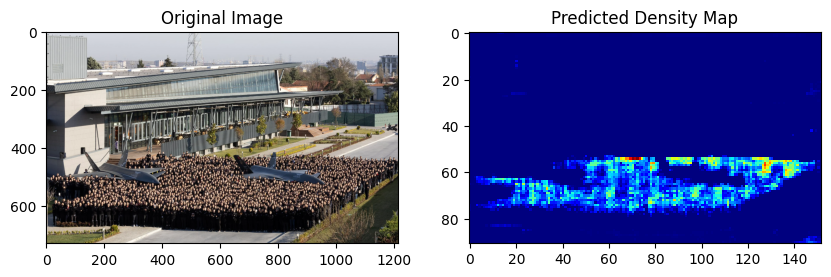

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "data/crowd.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed

# Preprocess the image (resize or normalize based on your training preprocessing)
# Ensure the preprocessing is consistent with what was done during training
# For example, you may need to resize the image to match the input size used during training

# Expand dimensions to create a batch of size 1 (as the model expects batches)
input_image = np.expand_dims(image, axis=0)

# Make predictions
predicted_density_map = model.predict(input_image)

# Normalize the density map values to be in the range [0, 1] for better visualization
normalized_density_map = predicted_density_map / np.max(predicted_density_map)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# Display the predicted density map as a heatmap
plt.subplot(1, 2, 2)
plt.imshow(normalized_density_map[0, :, :, 0], cmap='jet', interpolation='nearest')
plt.title('Predicted Density Map')

plt.show()

## Warp perspective

##### video + model heatmap

In [21]:
# Open the video file
video_path = "data/crowd2.mp4"
cap = cv2.VideoCapture(video_path)

# Get the original video's width, height, and fps
width = int(cap.get(3))
height = int(cap.get(4))
fps = cap.get(5)

# Create windows for the original video and the predicted density map
cv2.namedWindow("Original Video", cv2.WINDOW_NORMAL)
cv2.namedWindow("Predicted Density Map", cv2.WINDOW_NORMAL)

# Set a skip_frames variable to control how many frames to skip during processing
skip_frames = 5
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % skip_frames != 0:
        continue

    # Resize the frame to a smaller size for faster processing
    frame_resized = cv2.resize(frame, (640, 640))  # Adjust the size as needed
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    input_frame = np.expand_dims(frame_rgb, axis=0)

    predicted_density_map = model.predict(input_frame)
    # Resize the predicted density map to match the height and width of the original video frame
    predicted_density_map_resized = cv2.resize(predicted_density_map[0, :, :, 0], (width, height))
    # Normalize predicted density map values to range [0, 1]
    normalized_density_map = cv2.normalize(predicted_density_map_resized, None, 0, 1, cv2.NORM_MINMAX)

    
    # Apply a colormap (e.g., plasma)
    colored_density_map = (cm.jet(normalized_density_map) * 255).astype(np.uint8)
    # Convert the colored density map to RGB format
    colored_density_map_rgb = cv2.cvtColor(colored_density_map, cv2.COLOR_BGR2RGB)
    
    # Display the original video in one window
    cv2.imshow("Original Video", frame_resized)
    # Display the predicted density map in another window with adjusted color mapping
    cv2.imshow("Predicted Density Map", colored_density_map_rgb)

    delay = int(1000 / 8)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
# workign normal one with jet1

1/1 [==============================] - 0s 469ms/step


#### warp on image

In [14]:
import cv2

import numpy as np

img1 = cv2.imread('data/people.jpg')

# pixel values in original image
#inputPoints = np.float32([[0, 0], [img.shape[1], 0], [0, img.shape[1]], [img.shape[1], img.shape[1]]])
#inputPoints = np.float32([[0, 0], [1836, 0], [0, 971], [1836, 971]])
inputPoints = np.float32([[402, 86], [1424, 82], [0, 966], [1836, 971]])

# output image size
# width1 = 500
# height1 = 500

# width1 = 400
# height1 = int(width * 1.414)  # for A4

height = 400
width = int(height * 1.414)

# desired points values in the output image
convertedPoints = np.float32([[0,0],[width,0],[0,height],[width,height]])

# perspective transformation
matrix1 = cv2. getPerspectiveTransform(inputPoints, convertedPoints)
imgOutput = cv2.warpPerspective(img1, matrix1, (width, height))

cv2.imshow('Original', img1)
cv2.imshow('Warped perspective', imgOutput)

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
        
cv2.destroyAllWindows

<function destroyAllWindows>

#### warp on video

In [18]:
import cv2
import numpy as np

# Open a video capture object
cap = cv2.VideoCapture('data/person720.mp4')  # Replace 'your_video.mp4' with the path to your video file

# Output image size
height = 400
width = int(height * 1.414)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    # Pixel values in the original frame (you may need to modify this part)
    input_points = np.float32([[345, 70], [874, 70], [47, 696], [1134, 696]]) # correct warp
    #input_points = np.float32([[80, 55], [1074, 55], [80, 700], [1074, 700]])   # rect
    #input_points = np.float32([[200, 55], [966, 55], [80, 700], [1074, 700]])  # img like

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    frame_output = cv2.warpPerspective(frame, matrix, (width, height))

    # Display the original and warped frames
    cv2.imshow('Original', frame)
    cv2.imshow('Warped perspective', frame_output)

    # Break the loop if 'q' is pressed
    key = cv2.waitKey(int(1000 / 18)) & 0xFF
    if key == ord('q'):
        break
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

#### warp video + csrnet

In [54]:
import cv2
import numpy as np

# Open a video capture object
cap = cv2.VideoCapture('data/person720.mp4')  # Replace 'your_video.mp4' with the path to your video file

# Output image size
height = 400
width = int(height * 1.414)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
# Define skip frames and frame counter
skip_frames = 5
frame_count = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % skip_frames != 0:
        continue
        
    # Pixel values in the original frame (you may need to modify this part)
    input_points = np.float32([[345, 70], [874, 70], [47, 696], [1134, 696]]) # correct warp
    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    frame_output = cv2.warpPerspective(frame, matrix, (width, height))

    # Process and predict with your model on the warped area
    warped_area = frame_output[0:height, 0:width]  # Extract warped area
    warped_area_resized = cv2.resize(warped_area, (640, 640))  # Resize for model input
    warped_area_rgb = cv2.cvtColor(warped_area_resized, cv2.COLOR_BGR2RGB)
    input_frame = np.expand_dims(warped_area_rgb, axis=0)  # Add dimension for model
    
    predicted_density_map = model.predict(input_frame)
    predicted_density_map_resized = cv2.resize(predicted_density_map[0, :, :, 0], (width, height))
    normalized_density_map = cv2.normalize(predicted_density_map_resized, None, 0, 1, cv2.NORM_MINMAX)
    # Apply colormap and convert to RGB
    colored_density_map = (cm.jet(normalized_density_map) * 255).astype(np.uint8)
    colored_density_map_rgb = cv2.cvtColor(colored_density_map, cv2.COLOR_BGR2RGB)
    # Combine warped image and colored density map
    combined_image = cv2.addWeighted(frame_output, 0.5, colored_density_map_rgb, 0.5, 0)
    
    # Display the original and warped frames
    #cv2.imshow('Original', frame)
    cv2.imshow('Warped perspective', frame_output)
    # Display only the combined image (warped area with heatmap)
    cv2.imshow('Warped with density heatmap', combined_image)

    # Break the loop if 'q' is pressed
    key = cv2.waitKey(int(1000 / 18)) & 0xFF
    if key == ord('q'):
        break
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 476ms/step


In [67]:
import cv2
import numpy as np

# Open a video capture object
cap = cv2.VideoCapture('data/conference.mp4')  # Replace 'your_video.mp4' with the path to your video file

# Output image size
height = 400
width = int(height * 1.414)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
# Define skip frames and frame counter
skip_frames = 7
frame_count = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % skip_frames != 0:
        continue
        
    # Pixel values in the original frame (you may need to modify this part)
    input_points = np.float32([[345, 70], [874, 70], [47, 696], [1134, 696]]) # correct warp
    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    frame_output = cv2.warpPerspective(frame, matrix, (width, height))

    # Process and predict with your model on the warped area
    warped_area = frame_output[0:height, 0:width]  # Extract warped area
    warped_area_resized = cv2.resize(warped_area, (640, 640))  # Resize for model input
    warped_area_rgb = cv2.cvtColor(warped_area_resized, cv2.COLOR_BGR2RGB)
    input_frame = np.expand_dims(warped_area_rgb, axis=0)  # Add dimension for model
    
    predicted_density_map = model.predict(input_frame)
    predicted_density_map_resized = cv2.resize(predicted_density_map[0, :, :, 0], (width, height))
    normalized_density_map = cv2.normalize(predicted_density_map_resized, None, 0, 1, cv2.NORM_MINMAX)
    # Apply colormap and convert to RGB
    colored_density_map = (cm.plasma(normalized_density_map) * 255).astype(np.uint8)
    colored_density_map_rgb = cv2.cvtColor(colored_density_map, cv2.COLOR_BGR2RGB)
    # Combine warped image and colored density map
    combined_image = cv2.addWeighted(frame_output, 0.5, colored_density_map_rgb, 0.5, 0)
    
    # Display the original and warped frames
    #cv2.imshow('Original', frame)
    cv2.imshow('Warped perspective', frame_output)
    # Display only the combined image (warped area with heatmap)
    cv2.imshow('Warped with density heatmap', combined_image)

    # # Break the loop if 'q' is pressed
    # key = cv2.waitKey(int(1000 / 18)) & 0xFF
    # if key == ord('q'):
    if cv2.waitKey(10) == ord("q"):
        break
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 494ms/step
